# beomi/KcELECTRA-base

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6919295876661936702
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 51731365888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14737673166046040748
physical_device_desc: "device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:00:05.0, compute capability: 9.0"
xla_global_id: 416903419
]


In [2]:
import re
import torch
import pandas as pd

# GPU 설정
# 없을 시 CPU
# CPU로 뜨지만, GPU 잘만 돌아감
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda:0


In [3]:
# 엑셀 파일에서 데이터프레임 읽기
df = pd.read_excel(r"C:\Users\administrator\Desktop\X_filter\AI_Model\dataset\sentence_data(complete).xlsx")

print(df.shape)
df.head()

(214189, 2)


,Sentence,label
0,좌배 까는건 ㅇㅂ,1
1,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
2,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1
3,731부대의 후예라 그런지 가학적인 아이디어는 세계최고임 이래서 애교만 떨어도 돈 ...,1
4,재앙이한건햇노,1


In [4]:
null_idx = df[df.label.isnull()].index                             # 해당 index에 null 값 확인
df.loc[null_idx, "Sentence"]                                       # null 값이 존재한 인덱스의 content 값 불러오기

# lable은 content의 가장 끝 문장열로 설정
df.loc[null_idx, "label"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-1])

# content는 "\t" 앞부분까지의 문자열로 설정
df.loc[null_idx, "Sentence"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-2])

In [5]:
train_data = df.sample(frac=0.8, random_state=42)                 # train(80%), test(20%) 셋 구분 
test_data = df.drop(train_data.index)                             # 랜덤으로 샘플링(랜덤으로 숫자 배치)

# 데이터셋 갯수 확인
print('중복 제거 전 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 전 테스트 데이터셋 : {}'.format(len(test_data)))

# 중복 데이터 제거
train_data.drop_duplicates(subset=["Sentence"], inplace=True)
test_data.drop_duplicates(subset=["Sentence"], inplace=True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

중복 제거 전 학습 데이터셋 : 171351
중복 제거 전 테스트 데이터셋 : 42838
중복 제거 후 학습 데이터셋 : 167709
중복 제거 후 테스트 데이터셋 : 42587


In [6]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification, TFElectraForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# KcELECTRA 모델 및 토크나이저 로드
Kc_model = "beomi/kcbert-base"
Kc_tokenizer = AutoTokenizer.from_pretrained(Kc_model)

c:\Users\administrator\anaconda3\envs\Kc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_data

,Sentence,label
146620,어후 나는 내 몸 하나 건사하기 힘들다 키키,0
205991,어른들이니까 고기가 좋지 않을까?,0
146625,친구들이랑 같이 자취하는데 넘 귀엽더라 ㅠ,0
89212,"MBC ''좌빠''' 언론에다, ''라도''' 편향성 방송 제발 징계주어 나라망신 ...",1
57038,''시발''' 우리나라에는 한국사람들만 살게하고 #@이름# 동남아 ''짱깨''' '...,1
...,...,...
5887,2580 또 감성팔이했네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,1
188969,뭔가 민망한 상황에서 당당하다고 해야 하나 키키,0
46252,Nc가 집행검이벤트 한후 ''폭망하'''는중인데. ㅉㅉ 그리고. 다음의상은. 란제리좀부탁,1
28357,북한이랑 비슷하네 아님 북한이 더할수도멀리있지않다 우리옆에도 있는데 시한폭탄 북한 ...,1


In [8]:
tokenized_train_sentences = Kc_tokenizer( 
    list(train_data["Sentence"]),           # train_data 리스트화
    return_tensors="pt",                    # pytorch의 tensor 형태로 변환
    max_length=128,                         # 최대 토큰길이 설정
    padding=True,                           # 학습 시 빈 값을 0으로 대체
    truncation=True,                        # 초과 토큰 제거
    add_special_tokens=True                 # 추가 토큰 설정
)

In [9]:
tokenized_test_sentences = Kc_tokenizer(
    list(test_data["Sentence"]),           # test_data 리스트화
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

In [10]:
"""
CLS(분류 토큰)   : 시작을 알릴 때 사용
SEP(구분자 토큰) : 서로 다를 때 구분할 사용할 토큰
MASK            : 특정 토큰이 마스크화, 모델이 예측하도록 훈련
PAD             : 일관된 길이로 동일하게 만듦
                                                            """

'\nCLS(분류 토큰)   : 시작을 알릴 때 사용\nSEP(구분자 토큰) : 서로 다를 때 구분할 사용할 토큰\nMASK            : 특정 토큰이 마스크화, 모델이 예측하도록 훈련\nPAD             : 일관된 길이로 동일하게 만듦\n                                                            '

In [11]:
print(tokenized_train_sentences[0])        # 0번째 문장에 해당하는 객체
print("="*200) 
print(tokenized_train_sentences[0].tokens) # 0번째 문장에 토큰의 목록
print("="*200)
print(tokenized_train_sentences[0].ids)    # 0번째 문장에 대한 고유 ID

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '어', '##후', '나는', '내', '몸', '하나', '건', '##사', '##하기', '힘들다', '키', '##키', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [12]:
class CurseDataset(torch.utils.data.Dataset):                                        # 학습을 위한 데이터셋 만들기     
    def __init__(self, encoding, labels):                                            # pytorch에서 학습할 수 있게 데이터셋 생성
        self.encodings = encoding                                                    # Feature Data / 'Sentence'
        self.labels = labels                                                         # Target Data / 'Label'
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
        item["labels"] = torch.tensor(self.labels[idx])                             # key: toch.tensor(val[ix])라는 item 딕셔너리 형성
        return item                                                                 # 새로운 labels 키 값에 value torch.tensor(self.labels[idx]) 쌍을 생성
    
    def __len__(self):
        return len(self.labels)                                                     # self.labels 길이 반환

In [13]:
# train_set, test_set에 대한 데이터셋을 각각 생성
train_label = train_data["label"].values
test_label = test_data["label"].values

train_dataset = CurseDataset(tokenized_train_sentences, train_label)
test_dataset = CurseDataset(tokenized_test_sentences, test_label)

In [14]:
Kc_model = AutoModelForSequenceClassification.from_pretrained(Kc_model, num_labels=2)   # 사전 학습된 모델 찾아오기
Kc_model.to(device)                                                                     # num_labels 평가지표 확인

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [16]:
# Define the initial TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=500,
    save_total_limit=2,
)

In [17]:
# 학습과정에서 사용할 평가지표를 위한 함수 설정
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # 정밀도, 재현율, f1 구하기 
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  # 정확도 구하기
  acc = accuracy_score(labels, preds)
  return{
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

In [18]:
# Trainer 모듈을 사용해 모델의 학습을 컨트롤하은 trainer를 생성
trainer = Trainer(
    model = Kc_model,                    # 학습하고자하는 Transformers model
    args=training_args,                  # 위에서 정의한 학습 피라미터 설정
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [19]:
trainer.train()

 76%|███████▋  | 8000/10482 [08:16<02:17, 17.99it/s]

{'loss': 0.1275, 'learning_rate': 1.1839343636710553e-05, 'epoch': 0.76}


C:\Users\administrator\AppData\Local\Temp\2\ipykernel_8716\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
 81%|████████  | 8500/10482 [08:47<01:54, 17.38it/s]

{'loss': 0.1322, 'learning_rate': 9.454302614004962e-06, 'epoch': 0.81}


C:\Users\administrator\AppData\Local\Temp\2\ipykernel_8716\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
 86%|████████▌ | 9000/10482 [09:17<01:25, 17.42it/s]

{'loss': 0.134, 'learning_rate': 7.0692615912993714e-06, 'epoch': 0.86}


C:\Users\administrator\AppData\Local\Temp\2\ipykernel_8716\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
 91%|█████████ | 9500/10482 [09:48<00:56, 17.38it/s]

{'loss': 0.1104, 'learning_rate': 4.68422056859378e-06, 'epoch': 0.91}


C:\Users\administrator\AppData\Local\Temp\2\ipykernel_8716\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
 95%|█████████▌| 10000/10482 [10:18<00:27, 17.64it/s]

{'loss': 0.102, 'learning_rate': 2.2991795458881896e-06, 'epoch': 0.95}


C:\Users\administrator\AppData\Local\Temp\2\ipykernel_8716\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
100%|██████████| 10482/10482 [10:48<00:00, 16.16it/s]

{'train_runtime': 648.8347, 'train_samples_per_second': 258.477, 'train_steps_per_second': 16.155, 'train_loss': 0.13753338729896247, 'epoch': 1.0}


TrainOutput(global_step=10482, training_loss=0.13753338729896247, metrics={'train_runtime': 648.8347, 'train_samples_per_second': 258.477, 'train_steps_per_second': 16.155, 'train_loss': 0.13753338729896247, 'epoch': 1.0})

C:\Users\administrator\AppData\Local\Temp\2\ipykernel_8716\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
100%|██████████| 666/666 [00:30<00:00, 21.69it/s]


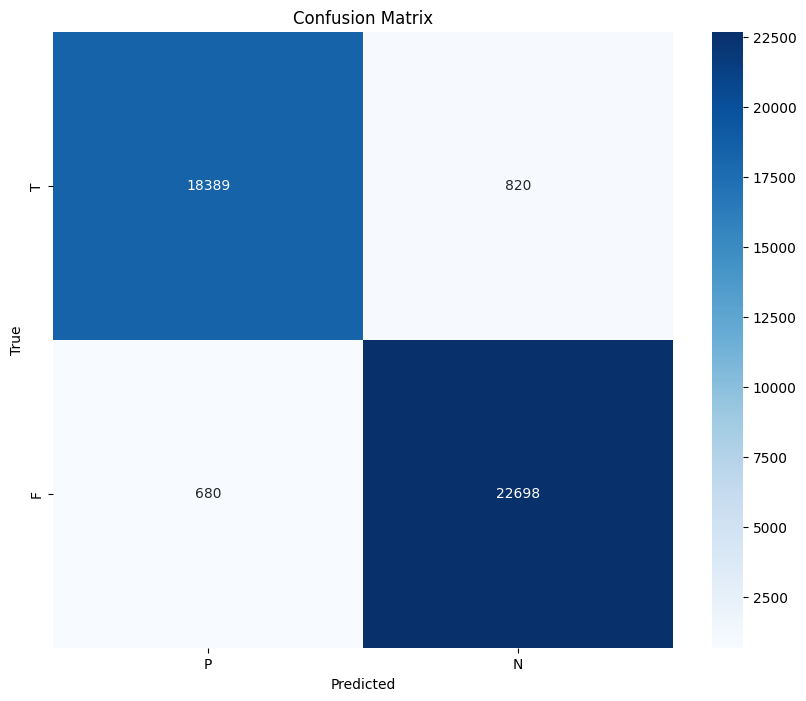

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluate on the test dataset
results = trainer.predict(test_dataset)

# Get the true labels and predicted logits
true_labels = results.label_ids
predicted_logits = results.predictions.argmax(-1)

# Calculate the confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_logits)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['P', 'N'], yticklabels=['T', 'F'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Specify the directory where you want to save the model
save_model_dir = "Kc_BERT_model"

# Save the model and tokenizer
Kc_model.save_pretrained(save_model_dir)
Kc_tokenizer.save_pretrained(save_model_dir)

('Kc_BERT_model\\tokenizer_config.json',
 'Kc_BERT_model\\special_tokens_map.json',
 'Kc_BERT_model\\vocab.txt',
 'Kc_BERT_model\\added_tokens.json',
 'Kc_BERT_model\\tokenizer.json')